In [1]:
import torch
import torch.nn as nn
import random
import pandas as pd
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'


print('Selected available:', device)

Selected available: cuda


In [2]:
# dataset = '../data-sets/Zinparen in Engels-Nederlands - 2024-10-21.csv'
dataset = '../data-sets/tokenized_sentences.csv'

df = pd.read_csv(
    filepath_or_buffer=dataset,
    names=['ENG_TOKENS', 'NLD_TOKENS'],
    nrows=5000000)



df

,ENG_TOKENS,NLD_TOKENS
0,"<SOS> They come from all parts of Egypt , just...","<SOS> Zij kwamen uit alle delen van Egypte , e..."
1,<SOS> You also will not make arbitrary conclus...,<SOS> Je zult ook geen willekeurige conclusies...
2,<SOS> [ 9 ] But how can he be seen from all si...,<SOS> [ 9 ] Maar hoe kan hij dan aan alle kant...
3,<SOS> No prophet of Mine will stand on a pedes...,<SOS> Geen profeet van Mij zal op een voetstuk...
4,<SOS> [ 3 ] This would be the case in 196 BCE ...,<SOS> [ 3 ] Dat zou het geval zijn in 196 BCE ...
...,...,...
4999995,<SOS> Our compromise with the bandits of Germa...,<SOS> Ons compromis met de bandieten van het D...
4999996,<SOS> N-VA proposes recommendations in the Eur...,<SOS> N-VA stelt aanbevelingen voor in Europes...
4999997,<SOS> Now Rowhani returns to the risky busines...,<SOS> Nu bemoeit Rohani zich opnieuw met de ri...
4999998,"<SOS> Meanwhile , I can invite others to come ...",<SOS> Ondertussen kan ik anderen uitnodigen om...


In [3]:
TRAIN_SPLIT = 0.9
MAX_SIZE = 20

FORBIDDEN_CHARS = ['€', '$', '[', ']', '(', ')', '{', '}', ';', '”', '-', '%', '@', '#', '^', '&', '*', '_',
	'+', '=', ':', '/', '\\']
FORBID_NUMERIC = True

''' Filter out bad input '''
def filter(row):
	eng_tokens = row['ENG_TOKENS'].split()
	nld_tokens = row['NLD_TOKENS'].split()

	if (len(eng_tokens) > MAX_SIZE):
		return False

	if (len(nld_tokens) > MAX_SIZE):
		return False

	if any(char in eng_tokens or char in nld_tokens for char in FORBIDDEN_CHARS):
		return False

	if FORBID_NUMERIC and (any(char.isdigit() for char in eng_tokens) or any(char.isdigit() for char in nld_tokens)):
		return False

	return True

df = df[df.apply(filter, axis=1)]

''' Splitting Training and Validation Data '''
df = df.sample(frac=1).reset_index(drop=True)
split = int(TRAIN_SPLIT * len(df))

train_data = df.iloc[:split, :]
test_data  = df.iloc[split:, :]
test_data.reset_index(drop=True, inplace=True)



print('Total rows from file:', len(df))
print('Total rows of train data:', len(train_data))
train_data

Total rows from file: 1633155
Total rows of train data: 1469839


,ENG_TOKENS,NLD_TOKENS
0,<SOS> Justin Uberti says that video chat will ...,<SOS> Justin uberti zegt dat videochat vandaag...
1,<SOS> What are Some Halloween Costume Ideas fo...,<SOS> Wat zijn enkele Halloween Costume Ideeën...
2,<SOS> It was instead merely just one of a numb...,<SOS> Het was in plaats daarvan slechts een va...
3,"<SOS> But , it 's so worth it in the end , you...","<SOS> Maar , het is zo de moeite waard op het ..."
4,"<SOS> Sierano , why did you want to become a d...","<SOS> Sierano , waarom wil je designer worden ..."
...,...,...
1469834,"<SOS> Here , Eindhoven ’ s technology and desi...",<SOS> Hier komt de tech en design van Eindhove...
1469835,<SOS> My need for disciples who realize the da...,<SOS> Mijn behoefte aan discipelen die het gev...
1469836,<SOS> We understand our filter is a new produc...,<SOS> Ons filter is immers een echt nieuw prod...
1469837,<SOS> Simply you have a visa and when you are ...,<SOS> Gewoon een visum en als je in Dubai bent...


In [4]:
from utils.Vocabulary import Vocabulary

''' Create a vocabulary to lookup indices '''
eng_vocab = Vocabulary('ENG')
nld_vocab = Vocabulary('NLD')

for sentence in train_data['ENG_TOKENS']:
    eng_vocab.add_sentence(sentence)

for sentence in train_data['NLD_TOKENS']:
    nld_vocab.add_sentence(sentence)

eng_vocab.trim()
nld_vocab.trim()



print('English vocab size:', len(eng_vocab))
print('Dutch vocab size:', len(nld_vocab))

English vocab size: 72655
Dutch vocab size: 95912


In [5]:
pad_index = 0 # Same for both ENG and NLD

# TODO: Make this multi threaded

''' Vectorize tokens '''
def build_dataset(subset):
	X = []
	Y = []

	for _, row in subset.iterrows():
		eng_ixs = eng_vocab.lookup_indices(row['ENG_TOKENS'].split())
		eng_ixs = eng_ixs + [pad_index] * (MAX_SIZE - len(eng_ixs))
		X.append(eng_ixs)

		nld_ixs = nld_vocab.lookup_indices(row['NLD_TOKENS'].split())
		nld_ixs = nld_ixs + [pad_index] * (MAX_SIZE - len(nld_ixs))
		Y.append(nld_ixs)

	X = torch.tensor(X, dtype=torch.long)
	Y = torch.tensor(Y, dtype=torch.long)

	return X, Y


Xtr, Ytr = build_dataset(train_data)
Xte, Yte = build_dataset(test_data)



print('Xtr shape:', Xtr.shape)
print()
print('Random vector:')
ix = random.randint(0, len(Xtr))
print(Xtr[ix].tolist())
print(Ytr[ix].tolist())
print()
print(eng_vocab.lookup_tokens(Xtr[ix].tolist()))
print(nld_vocab.lookup_tokens(Ytr[ix].tolist()))


Xtr shape: torch.Size([1469839, 20])

Random vector:
[1, 2106, 141, 401, 6478, 49, 1247, 162, 49, 7675, 24, 1247, 6, 3995, 649, 10, 8338, 17, 2, 0]
[1, 2108, 43, 338, 12043, 27, 1224, 154, 1140, 8235, 47, 1224, 79, 98, 54, 8968, 230, 14, 2, 0]

['<SOS>', 'There', 'is', 'no', 'lie', 'in', 'war', 'or', 'in', 'preparation', 'for', 'war', 'that', 'ca', "n't", 'be', 'defended', '.', '<EOS>', '<PAD>']
['<SOS>', 'Er', 'is', 'geen', 'leugen', 'in', 'oorlog', 'of', 'ter', 'voorbereiding', 'op', 'oorlog', 'die', 'niet', 'worden', 'verdedigd', 'kan', '.', '<EOS>', '<PAD>']


In [6]:
''' Hyperparameters: '''

# Model parameters
emb_dim       = 100
hidden_size   = 300 # The same hidden size for encoder and decoder
num_layers    =   3
dropout       =   0

# Training parameters
batch_size    = 256
epochs        = 3
learning_rate = 0.00003 # If you double the bs, you might double the lr
weight_decay  = 0.000005 # Penalize complexity by couting weights into the loss function
forced_teaching_start_ratio = 1
forced_teaching_final_ratio = 0

In [7]:
from torch.utils.data import DataLoader, TensorDataset

''' Create DataLoaders '''
train_dataset = TensorDataset(Xtr, Ytr)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)

test_dataset = TensorDataset(Xte, Yte)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)


In [8]:
from RNN.Seq2Seq import Seq2Seq

''' Construct the model '''
model = Seq2Seq(
    len(eng_vocab),
    len(nld_vocab),
    emb_dim,
    hidden_size,
    hidden_size,
    num_layers,
    dropout,
).to(device)



''' Display where all the model's parameters are exactly located '''
def count_params(module, indent=0, module_name=""):
    total_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

    name_str = f"{module_name} ({module.__class__.__name__})" if module_name else module.__class__.__name__
    print(f'{"  " * indent}- {name_str}: {total_params:,d}')

    for name, submodule in module.named_children():
        count_params(submodule, indent + 1, name)

count_params(model)

- Seq2Seq: 52,163,312
  - encoder (Encoder): 11,236,300
    - embeddings (Embedding): 7,265,500
    - rnn (GRU): 3,970,800
    - dropout (Dropout): 0
  - decoder (Decoder): 40,746,712
    - embeddings (Embedding): 9,591,200
    - attention (Attention): 450,300
      - W1 (Linear): 270,000
      - W2 (Linear): 180,000
      - V (Linear): 300
    - input_fc (Linear): 210,300
    - rnn (GRU): 1,625,400
    - fc (Linear): 28,869,512
    - dropout (Dropout): 0
  - fc_hidden (Linear): 180,300


In [9]:
# https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html



criterion = nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [10]:
'''
Helper functions for the training loop
'''

''' Calculate a teaching ratio, starts with a high ratio and lowers throughout training '''
def forced_teaching_ratio(current_epoch, total_epochs):
    start_ratio = forced_teaching_start_ratio
    final_ratio = forced_teaching_final_ratio
    progress = current_epoch / total_epochs
    return start_ratio - (start_ratio - final_ratio) * progress

''' Calculate loss on train and test data '''
@torch.inference_mode()
def log_statistics(eval_batch_size=64):

    # Create a completely empty 'target' for the model
    empty_target = torch.zeros((eval_batch_size, MAX_SIZE), dtype=torch.long).to(device)
    empty_target[:, 0] = 1 # <SOS> has index of 1

    model.eval()

    # Train dataset evaluation
    inputs, targets = next(iter(train_loader))
    inputs, targets = inputs.to(device), targets.to(device)

    outputs = model(inputs, empty_target)
    train_loss = criterion(outputs, targets)


    # Test dataset evaluation
    inputs, targets = next(iter(test_loader))
    inputs, targets = inputs.to(device), targets.to(device)

    outputs = model(inputs, empty_target)
    test_loss = criterion(outputs, targets)

    return train_loss.item(), test_loss.item()

def compute_l2_weights(model):
    total_l2_norm = 0
    for param in model.parameters():
        if param.requires_grad:  # Ensure we only compute L2 norm for weights that require gradients
            total_l2_norm += torch.norm(param, p=2).item()  # Compute the L2 norm (p=2)
    return total_l2_norm

def compute_weight_stats(model):
    total_sum = 0
    total_sum_sq = 0
    param_count = 0

    for param in model.parameters():
        if param.requires_grad:
            param_data = param.data.view(-1)  # Flatten the tensor to 1D
            total_sum += param_data.sum().item()
            total_sum_sq += (param_data ** 2).sum().item()
            param_count += param.numel()

    if param_count == 0:
        return 0, 0

    # Compute the mean
    mean = total_sum / param_count

    # Compute the variance and standard deviation
    variance = (total_sum_sq / param_count) - (mean ** 2)
    std_dev = variance ** 0.5

    return mean, std_dev

def compute_gradient_norm_per_module(model):
    gradient_norms = {}

    # Iterate over each submodule in the model
    for name, module in model.named_modules():
        total_norm = 0
        grad_count = 0

        # Calculate gradient norm for this specific submodule
        for param in module.parameters(recurse=False):  # Only parameters directly in this module
            if param.grad is not None:
                total_norm += param.grad.data.norm(2).item()
                grad_count += param.numel()

        # Store the gradient norm for this submodule
        if grad_count > 0:
            gradient_norms[name] = total_norm / grad_count

    return gradient_norms

In [11]:
from tqdm.notebook import tqdm

reference_iter      = []
train_loss_values   = []
test_loss_values    = []
l2_norms            = []
weight_means        = []
weight_stds         = []
submodule_gradients = {}  # Dictionary to store gradients for each submodule

global_iteration = 0
total_iterations = epochs * len(train_loader)

# Initialize submodule gradient lists for each submodule
for name, _ in model.named_modules():
    submodule_gradients[name] = []

for epoch in tqdm(range(epochs), desc="Epochs"):

    for inputs, targets in tqdm(train_loader, desc="Batches", leave=False):
        model.train()
        global_iteration += 1
        ft_ratio = forced_teaching_ratio(global_iteration, total_iterations)

        ''' Sample mini-batch and send to gpu '''
        inputs, targets = inputs.to(device), targets.to(device)

        ''' Perform a single training iteration '''
        output = model(inputs, targets, ft_ratio) # Do the forward pass
        loss = criterion(output, targets)         # Calculate the loss
        optimizer.zero_grad()                     # Reset parameters
        loss.backward()                           # Backpropagation
        optimizer.step()                          # Update parameters

        ''' Report progression every so often '''
        if ((global_iteration + 1) % (total_iterations // 50) == 0 or global_iteration == total_iterations):
            train_loss, test_loss = log_statistics(batch_size)

            reference_iter.append(global_iteration)
            train_loss_values.append(train_loss)
            test_loss_values.append(test_loss)

            l2_norms.append(compute_l2_weights(model))

            ''' Compute mean and std dev of weights '''
            mean_weight, std_weight = compute_weight_stats(model)
            weight_means.append(mean_weight)
            weight_stds.append(std_weight)

            ''' Collect gradient norms per submodule '''
            grad_norms = compute_gradient_norm_per_module(model)
            for name, grad_norm in grad_norms.items():
                submodule_gradients[name].append(grad_norm)


        if (global_iteration == total_iterations):
            # Print final results
            print()
            print('Final training loss:', round(train_loss, 3))
            print('Final test loss:    ', round(test_loss, 3))

Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5742 [00:00<?, ?it/s]

Batches:   0%|          | 0/5742 [00:00<?, ?it/s]

Batches:   0%|          | 0/5742 [00:00<?, ?it/s]


Final training loss: 4.089
Final test loss:     4.116


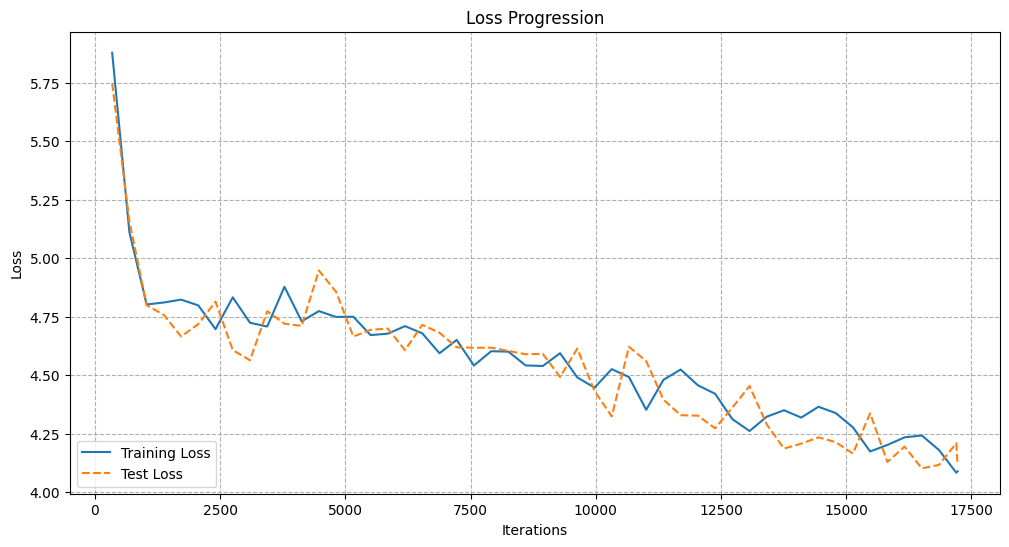

In [12]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
plt.grid(ls='--')

ax1.plot(reference_iter, train_loss_values, label='Training Loss')
ax1.plot(reference_iter, test_loss_values, label='Test Loss', linestyle='--')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Progression')

ax1.legend(loc='lower left')
plt.show()

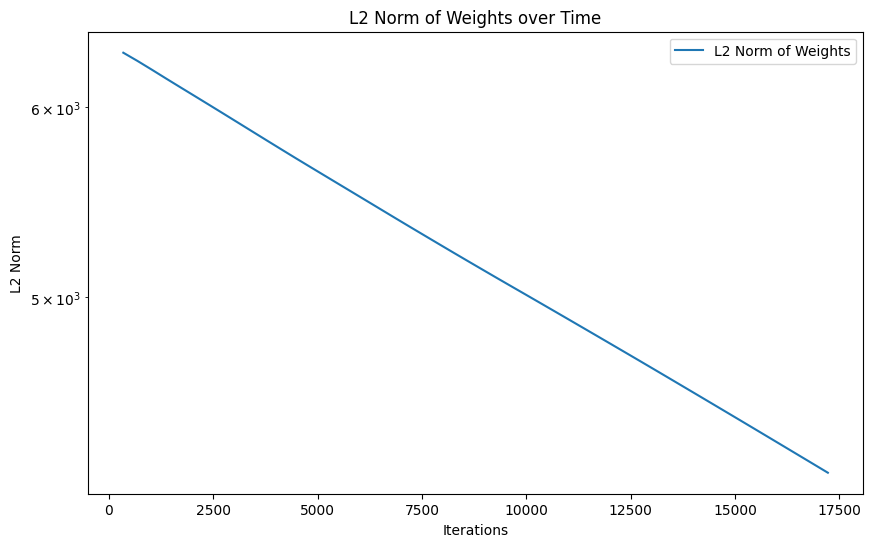

In [13]:
plt.figure(figsize=(10, 6))

plt.plot(reference_iter, l2_norms, label="L2 Norm of Weights")
plt.xlabel("Iterations")
plt.ylabel("L2 Norm")
plt.title("L2 Norm of Weights over Time")

plt.yscale('log')

plt.legend()
plt.show()

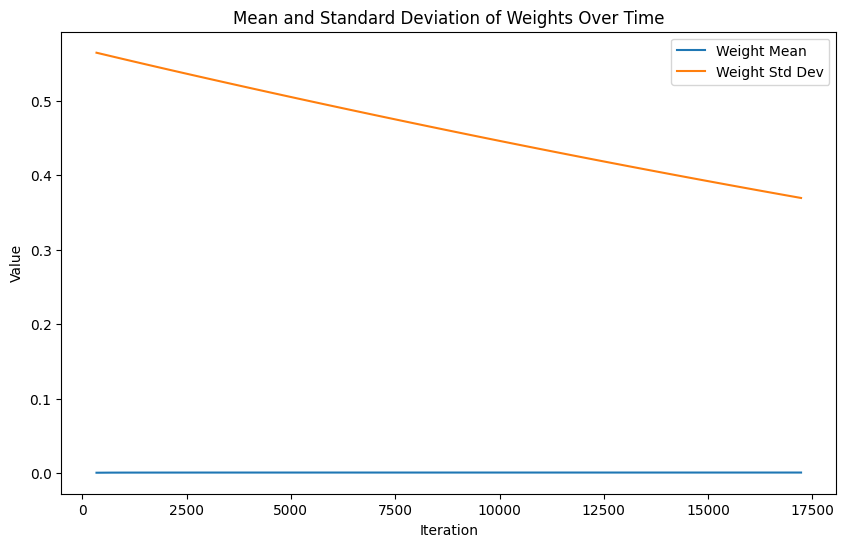

In [14]:
plt.figure(figsize=(10, 6))

plt.plot(reference_iter, weight_means, label='Weight Mean')
plt.plot(reference_iter, weight_stds, label='Weight Std Dev')

plt.xlabel("Iteration")
plt.ylabel("Value")
plt.title("Mean and Standard Deviation of Weights Over Time")

plt.legend()
plt.show()


A gradual decrease typically indicates the effect of weight decay, which penalizes large weights and encourages the model to prefer smaller weights. This reduces overfitting.

Excessive decrease might suggest that the weight decay is too strong, causing weights to become too small. The model is restricted to capture complex data.

Large weight norms or fluctuations are undesirable.

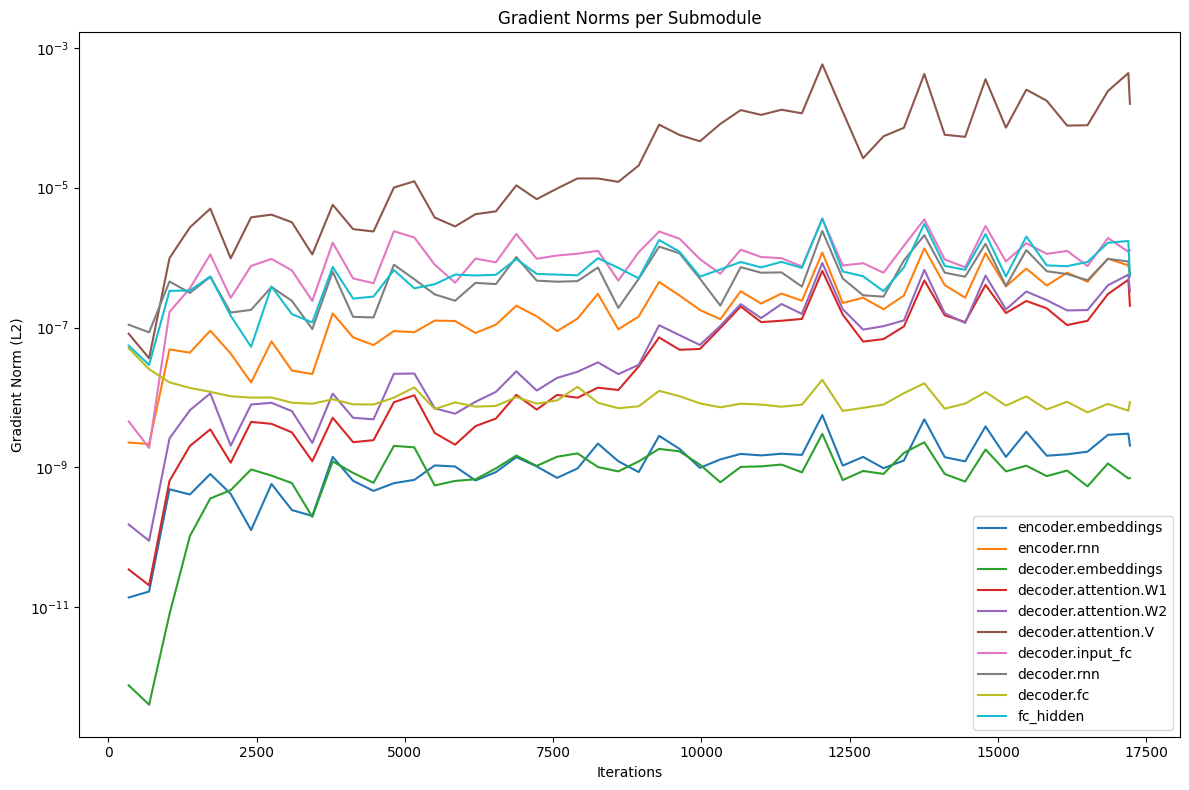

In [15]:
plt.figure(figsize=(12, 8))

for name, norms in submodule_gradients.items():
    if norms:
        plt.plot(reference_iter, norms, label=name)

plt.xlabel("Iterations")
plt.ylabel("Gradient Norm (L2)")
plt.title("Gradient Norms per Submodule")
plt.legend()

# Set the y-axis to logarithmic scale
plt.yscale('log')

plt.tight_layout()
plt.show()


Large gradient norms could indicate that the learning rate is too high, causing the model to take very large steps each optimization step.

If the gradients are close to zero, the model might be stuck in a (local) minima. The learning rate may be too low.

If the gradients gradually reduce during training, the model is converging as the weights are being fine-tuned with smaller updates.

Sudden spikes are not ideal.

In [16]:
# torch.save(model.state_dict(), '../models/RNN-Attention_24-10-2024.pt')

In [17]:
# import os.path

# if os.path.isfile('../models/RNN-Attention_24-10-2024.pt'):
#     print('Found saved state dictionary!')
#     model.load_state_dict(torch.load('../models/RNN-Attention_24-10-2024.pt'))

In [18]:
import nltk
from nltk.tokenize import word_tokenize

# Download the tokenizer models from nltk
nltk.download('punkt')
nltk.download('punkt_tab')

def tokenize_sentence(sentence: str) -> list:
    """Tokenize a single sentence."""
    return ['<SOS>'] + word_tokenize(sentence) + ['<EOS>']


[nltk_data] Downloading package punkt to /home/ocmkieboom/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/ocmkieboom/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [19]:
import re

def translate(sentence, max_output_length=20):
	input_tokens = tokenize_sentence(sentence)
	input_indices = eng_vocab.lookup_indices(input_tokens)

	output_indices, _ = model.evaluate(input_indices, device, max_output_length)
	output_tokens = nld_vocab.lookup_tokens(output_indices)

	new_sentence = ' '.join(output_tokens).capitalize()
	new_sentence = re.sub(r'\s+([.,!?])', r'\1', new_sentence)

	return new_sentence

In [20]:
### Use model ###

print(translate('Go!'))
print(translate('It\'s not Fine.'))
print(translate('I\'m very happy today.'))
print(translate('He\'s very sad.'))
print(translate('That man is wearing a white shirt.'))
print(translate('He\'s very afraid of spiders.'))
print(translate('He\'s going home to his wife.'))
print(translate('Those guys are walking to work.'))
print(translate('I\'m not going with you today.'))
print(translate('My girlfriend will not come over tomorrow.'))
print(translate('He bought his friends a present for christmas.'))


<sos> wat het een een een een een een een een <eos>
<sos> het is dat dat niet niet niet niet niet niet... <pad> <pad> <pad> <pad> <pad> <pad>
<sos> ik heb dat dat dat een een dat dat een... <pad> <pad> <pad> <pad> <pad> <pad>
<sos> hij is niet niet dat het de is is is.. <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<sos> dat <unk> in is is dat een een een een een een.. <pad> <pad> <pad> <pad> <pad>
<sos> hij is niet,, de de van van van de... <pad> <pad> <pad> <pad> <pad>
<sos> hij is niet zijn om om om om om zijn zijn. <eos>
<sos> in deze <unk> zijn,,, om om te te te.. <pad> <pad> <pad> <pad> <pad>
<sos> ik heb ik ik ik dat dat dat je je je... <pad> <pad> <pad> <pad> <pad>
<sos> alle <unk> zijn dat niet niet dat het de de te... <pad> <pad> <pad> <pad> <pad>
<sos> hij is ook dat dat dat een een een een voor voor voor.. <pad> <pad> <pad> <pad>


In [21]:
import matplotlib.pyplot as plt

def evaluateAndShowAttention():

    # Sample a random sentence from the test data
    input_tokens = test_data.sample()['ENG_TOKENS'].iloc[0].split()
    input_indices = eng_vocab.lookup_indices(input_tokens)

    output_indices, attentions = model.evaluate(input_indices, device)
    output_indices = output_indices[1:] # Remove single batch dimension
    output_tokens = nld_vocab.lookup_tokens(output_indices)

    output_tokens.insert(0, "<SOS>")

    attentions = attentions.cpu().numpy()

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='plasma')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(range(len(input_tokens)))
    ax.set_yticks(range(len(output_tokens)))

    ax.set_xticklabels(input_tokens, rotation=90)
    ax.set_yticklabels(output_tokens)

    plt.show()

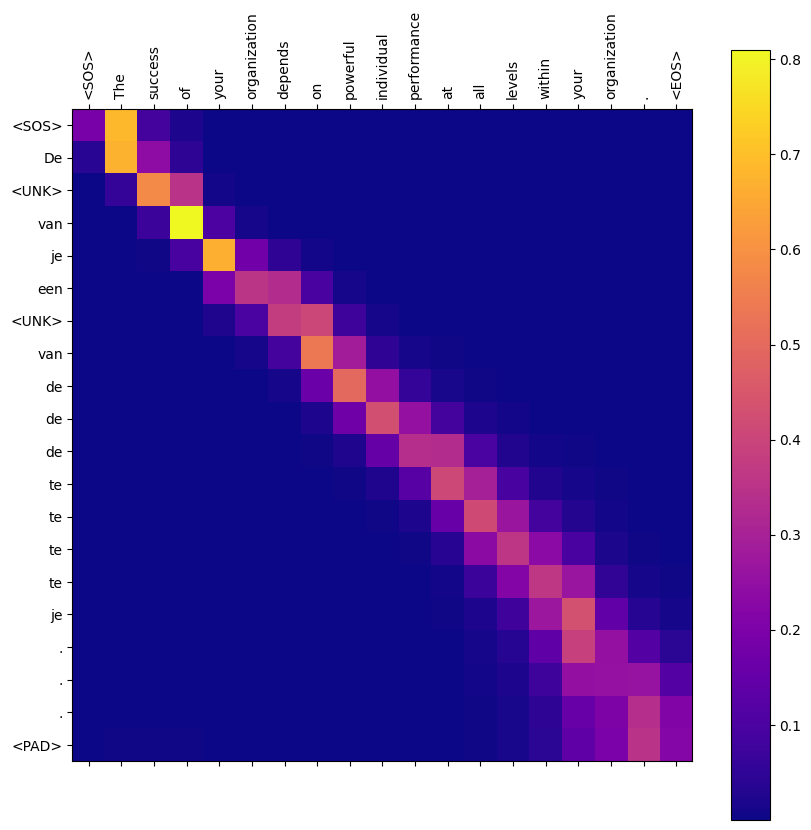

In [25]:
evaluateAndShowAttention()